# [**Estimation de Covariance Robuste vs. Empirique**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/covariance/plot_robust_vs_empirical_covariance.ipynb)<br/>([_Robust covariance estimation and Mahalanobis distances relevance_](https://scikit-learn.org/stable/auto_examples/covariance/plot_robust_vs_empirical_covariance.html))

L'estimation usuelle de la covariance par le maximum de vraisemblance est très sensible à la présence d'outliers dans l'ensemble de données. Dans de tels cas, il serait préférable d'utiliser un estimateur de covariance robuste pour garantir que l'estimation est résistante aux observations "erronées" dans l'ensemble de données [1], [2].

# Estimateur de détermination de covariance minimale (Minimum Covariance Determinant Estimator)

L'estimateur de détermination de covariance minimale (Minimum Covariance Determinant, MCD) est un estimateur robuste, avec un point de rupture élevé (c'est-à-dire qu'il peut être utilisé pour estimer la matrice de covariance d'ensembles de données fortement contaminés, jusqu'à $\frac{n_\text{samples} - n_\text{features}-1}{2}$ outliers). L'idée derrière le MCD est de trouver $\frac{n_\text{samples} + n_\text{features}+1}{2}$ observations dont la covariance empirique a le déterminant le plus petit, fournissant un sous-ensemble "pur" d'observations à partir duquel on peut calculer des estimations standards de la position et de la covariance. Après une étape de correction visant à compenser le fait que les estimations ont été apprises à partir d'une partie seulement des données initiales, nous obtenons des estimations robustes de la position et de la covariance de l'ensemble de données.

L'estimateur de détermination de covariance minimale (MCD) a été introduit par P.J.Rousseuw dans [3].

# Évaluation

Dans cet exemple, nous comparons les erreurs d'estimation commises lors de l'utilisation de divers types d'estimations de position et de covariance sur des ensembles de données distribuées selon une loi gaussienne et contaminées :

- La moyenne et la covariance empirique de l'ensemble complet des données, qui perdent en précision dès qu'il y a des outliers dans l'ensemble de données
- Le MCD robuste, qui a une faible erreur à condition que $n_\text{samples} > 5n_\text{features}$
- La moyenne et la covariance empirique des observations connues pour être des valeurs normales. Ceci peut être considéré comme une estimation "parfaite" du MCD, ce qui nous permet de vérifier la fiabilité de notre implémentation en comparant les résultats à ce cas.

# Références

[1] Johanna Hardin, David M Rocke. The distribution of robust distances. Journal of Computational and Graphical Statistics. December 1, 2005, 14(4): 928-946.

[2] Zoubir A., Koivunen V., Chakhchoukh Y. and Muma M. (2012). Robust estimation in signal processing: A tutorial-style treatment of fundamental concepts. IEEE Signal Processing Magazine 29(4), 61-80.

[3] P. J. Rousseeuw. Least median of squares regression. Journal of American Statistical Ass., 79:871, 1984.

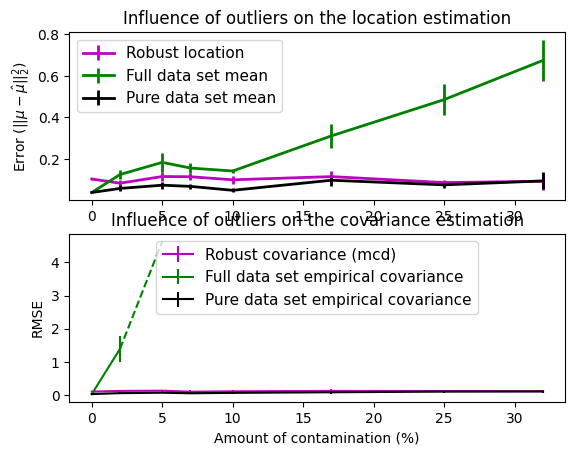

In [1]:
import matplotlib.font_manager
import matplotlib.pyplot as plt
import numpy as np

from sklearn.covariance import EmpiricalCovariance, MinCovDet

# example settings
n_samples = 80
n_features = 5
repeat = 10

range_n_outliers = np.concatenate(
    (
        np.linspace(0, n_samples / 8, 5),
        np.linspace(n_samples / 8, n_samples / 2, 5)[1:-1],
    )
).astype(int)

# definition of arrays to store results
err_loc_mcd = np.zeros((range_n_outliers.size, repeat))
err_cov_mcd = np.zeros((range_n_outliers.size, repeat))
err_loc_emp_full = np.zeros((range_n_outliers.size, repeat))
err_cov_emp_full = np.zeros((range_n_outliers.size, repeat))
err_loc_emp_pure = np.zeros((range_n_outliers.size, repeat))
err_cov_emp_pure = np.zeros((range_n_outliers.size, repeat))

# computation
for i, n_outliers in enumerate(range_n_outliers):
    for j in range(repeat):
        rng = np.random.RandomState(i * j)

        # generate data
        X = rng.randn(n_samples, n_features)
        # add some outliers
        outliers_index = rng.permutation(n_samples)[:n_outliers]
        outliers_offset = 10.0 * (
            np.random.randint(2, size=(n_outliers, n_features)) - 0.5
        )
        X[outliers_index] += outliers_offset
        inliers_mask = np.ones(n_samples).astype(bool)
        inliers_mask[outliers_index] = False

        # fit a Minimum Covariance Determinant (MCD) robust estimator to data
        mcd = MinCovDet().fit(X)
        # compare raw robust estimates with the true location and covariance
        err_loc_mcd[i, j] = np.sum(mcd.location_**2)
        err_cov_mcd[i, j] = mcd.error_norm(np.eye(n_features))

        # compare estimators learned from the full data set with true
        # parameters
        err_loc_emp_full[i, j] = np.sum(X.mean(0) ** 2)
        err_cov_emp_full[i, j] = (
            EmpiricalCovariance().fit(X).error_norm(np.eye(n_features))
        )

        # compare with an empirical covariance learned from a pure data set
        # (i.e. "perfect" mcd)
        pure_X = X[inliers_mask]
        pure_location = pure_X.mean(0)
        pure_emp_cov = EmpiricalCovariance().fit(pure_X)
        err_loc_emp_pure[i, j] = np.sum(pure_location**2)
        err_cov_emp_pure[i, j] = pure_emp_cov.error_norm(np.eye(n_features))

# Display results
font_prop = matplotlib.font_manager.FontProperties(size=11)
plt.subplot(2, 1, 1)
lw = 2
plt.errorbar(
    range_n_outliers,
    err_loc_mcd.mean(1),
    yerr=err_loc_mcd.std(1) / np.sqrt(repeat),
    label="Robust location",
    lw=lw,
    color="m",
)
plt.errorbar(
    range_n_outliers,
    err_loc_emp_full.mean(1),
    yerr=err_loc_emp_full.std(1) / np.sqrt(repeat),
    label="Full data set mean",
    lw=lw,
    color="green",
)
plt.errorbar(
    range_n_outliers,
    err_loc_emp_pure.mean(1),
    yerr=err_loc_emp_pure.std(1) / np.sqrt(repeat),
    label="Pure data set mean",
    lw=lw,
    color="black",
)
plt.title("Influence of outliers on the location estimation")
plt.ylabel(r"Error ($||\mu - \hat{\mu}||_2^2$)")
plt.legend(loc="upper left", prop=font_prop)

plt.subplot(2, 1, 2)
x_size = range_n_outliers.size
plt.errorbar(
    range_n_outliers,
    err_cov_mcd.mean(1),
    yerr=err_cov_mcd.std(1),
    label="Robust covariance (mcd)",
    color="m",
)
plt.errorbar(
    range_n_outliers[: (x_size // 5 + 1)],
    err_cov_emp_full.mean(1)[: (x_size // 5 + 1)],
    yerr=err_cov_emp_full.std(1)[: (x_size // 5 + 1)],
    label="Full data set empirical covariance",
    color="green",
)
plt.plot(
    range_n_outliers[(x_size // 5) : (x_size // 2 - 1)],
    err_cov_emp_full.mean(1)[(x_size // 5) : (x_size // 2 - 1)],
    color="green",
    ls="--",
)
plt.errorbar(
    range_n_outliers,
    err_cov_emp_pure.mean(1),
    yerr=err_cov_emp_pure.std(1),
    label="Pure data set empirical covariance",
    color="black",
)
plt.title("Influence of outliers on the covariance estimation")
plt.xlabel("Amount of contamination (%)")
plt.ylabel("RMSE")
plt.legend(loc="upper center", prop=font_prop)

plt.show()